# Hospital Staffing Optimization with Genetic Algorithms

This notebook provides a comprehensive walkthrough of the Hospital Simulation system and the Genetic Algorithm (GA) used to optimize staffing schedules. Our goal is to minimize total operational costs, which include:
- **Staffing Costs**: Hourly wages and setup costs for temporary staff.
- **Waiting Costs**: Penalties for patients waiting too long for care.
- **Diversion Costs**: High penalties when the ER is at capacity and ambulances must be diverted.

## 1. Setup and Configuration

First, we import the necessary modules and load the simulation configuration. The configuration defines arrival rates, department capacities, costs, and patient flow probabilities.

In [1]:
import sys
import os

# Ensure the project root is in the path
project_root = '/Users/shauryaguleria/Documents/School/Hospital Optimizer'
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import from the simulation package
try:
    from simulation.config import ARRIVAL_RATES, CAPACITY, COSTS, INITIAL_STAFF
except ImportError:
    # Fallback/Debug if something is wrong with the path
    print("Error importing config. Checking path...")
    print(sys.path)
    raise

import pandas as pd
import matplotlib.pyplot as plt

print("Configuration Loaded.")
print(f"Departments: {list(CAPACITY.keys())}")
print(f"Initial Staffing: {INITIAL_STAFF}")

Configuration Loaded.
Departments: ['ER', 'Surgery', 'CriticalCare', 'StepDown']
Initial Staffing: {'ER': 18, 'Surgery': 6, 'CriticalCare': 13, 'StepDown': 24}


### Key Configuration Highlights

The simulation is driven by several key parameters defined in `simulation/config.py`:

- **Arrival Rates**: Fluctuate by hour of day (e.g., higher arrivals in the morning/evening).
- **Costs**: 
    - **Wait**: Cost per hour a patient waits.
    - **Diversion**: $5,000 penalty for diverting an ambulance.
    - **Extra Staff**: $40/hr for temporary staff.
- **Patient Flow**: Probabilities determine how patients move from ER -> Surgery -> Critical Care -> etc.

---

## 2. The Hospital Simulation Model

The core simulation is implemented in `simulation/hospital.py` (formerly simulation.py). It uses `simpy`, a discrete-event simulation framework.

### How it works:
1. **Arrival Generator**: Creates patients based on Poisson distribution rates for each hour.
2. **Patient Flow**: 
    - Patients arrive at the **ER**.
    - If resources (Beds/Staff) are available, they are treated.
    - If not, they wait (accumulating Wait Cost) or are diverted (Diversion Cost).
    - After treatment, they may be discharged or transferred to **Surgery**, **CriticalCare**, or **StepDown**.
3. **Resource Management**: Each department has a limited number of **beds** and **staff** (Doctors/Nurses). 
    - Staff levels can change hourly based on the **Staffing Schedule**.

The `HospitalSimulation` class takes a `staffing_schedule` as input. If none is provided, it uses the static `INITIAL_STAFF` for all 24 hours.

In [2]:
# Import simulation class from the package
from simulation.hospital import HospitalSimulation

# Run a Baseline Simulation (No Optimization)
print("Running Baseline Simulation with Initial Staffing...")
baseline_sim = HospitalSimulation(duration_hours=24, staffing_schedule=None)
baseline_cost = baseline_sim.run()

print(f"Baseline Total Cost: ${baseline_cost:,.2f}")

Running Baseline Simulation with Initial Staffing...
Baseline Total Cost: $270,470.58


---

## 3. Genetic Algorithm (GA) Implementation

To find the best staffing schedule, we use a Genetic Algorithm. This is an optimization technique inspired by natural selection.

### Why GA?
The search space is huge. We have **24 hours**, and for each hour, we can adjust staff levels for **4 departments**. 
If we allow just ±2 staff variance per department per hour, that's $5^{4 \times 24}$ combinations! A brute force search is impossible. GA allows us to evolve towards a good solution efficiently.

### Components of our GA (`simulation/optimizer.py`)

1.  **Genome (The Solution)**:
    - A dictionary representing the schedule: `{Hour: {Dept: Count}}`.
    - Example: `{0: {'ER': 20, ...}, 1: {'ER': 18, ...}}`.

2.  **Population**:
    - A collection of random schedules (genomes). We start with a population size of 5.

3.  **Fitness Function (Evaluation)**:
    - The fitness of a schedule is the **Total Cost** returned by the simulation.
    - Lower Cost = Higher Fitness.
    - *Note*: Since simulation is stochastic (random arrivals), we run it multiple times (e.g., 5 iterations) and average the cost to get a stable score.

4.  **Selection**:
    - We sort the population by cost and keep the top 50% ("Survival of the Fittest").

5.  **Crossover (Reproduction)**:
    - We create new schedules by combining parts of two parent schedules.
    - Example: Take morning shifts from Parent A and evening shifts from Parent B.

6.  **Mutation**:
    - With a small probability (`MUTATION_RATE`), we slightly tweak a schedule (e.g., add/remove 1 staff member) to introduce variety and prevent getting stuck in local optima.

In [3]:
# Import optimizer from the package
import importlib
import simulation.optimizer
importlib.reload(simulation.optimizer)
from simulation.optimizer import StaffingOptimizer

# Genetic Algorithm Parameters
POPULATION_SIZE = 5
GENERATIONS = 100
MUTATION_RATE = 0.1
ELITISM = 2

# Initialize the Optimizer
optimizer = StaffingOptimizer(
    population_size=POPULATION_SIZE,
    generations=GENERATIONS,
    mutation_rate=MUTATION_RATE,
    elitism=ELITISM
)

# Explain parameters
print(f"Population Size: {POPULATION_SIZE}")
print(f"Generations: {GENERATIONS}")
print(f"Mutation Rate: {MUTATION_RATE}")
print(f"Elitism: {ELITISM}")


Population Size: 5
Generations: 100
Mutation Rate: 0.1
Elitism: 2


---

## 4. Running the Optimization

We will now run the Genetic Algorithm. It will iterate through generations, evolving the population to minimize cost.

**Watch the output below:** You should see the "Best Cost" decrease (or stay stable if already optimal) compared to the Baseline.

In [4]:
# Run the optimization
# This might take a minute as it runs multiple simulations per individual per generation.
best_schedule, min_cost = optimizer.run()

Starting Optimization...


Generation 0: New Best Cost (5-eval) = 191,754.46 | Baseline Cost = 285,243.27


Generation 1: Best Cost (5-eval) = 191,754.46 | Baseline Cost = 245,950.90


Generation 2: New Best Cost (5-eval) = 182,816.76 | Baseline Cost = 237,727.09


Generation 3: New Best Cost (5-eval) = 158,427.26 | Baseline Cost = 192,563.79


Generation 4: New Best Cost (5-eval) = 151,662.99 | Baseline Cost = 224,798.04


Generation 5: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 266,851.59


Generation 6: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 223,948.31


Generation 7: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 217,164.30


Generation 8: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 292,669.23


Generation 9: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 303,603.01


Generation 10: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 224,007.37


Generation 11: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 235,728.89


Generation 12: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 219,050.86


Generation 13: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 214,231.67


Generation 14: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 286,086.67


Generation 15: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 252,941.72


Generation 16: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 283,008.87


Generation 17: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 250,498.47


Generation 18: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 259,036.98


Generation 19: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 235,563.91


Generation 20: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 244,234.14


Generation 21: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 194,311.75


Generation 22: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 277,396.93


Generation 23: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 192,392.91


Generation 24: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 244,429.52


Generation 25: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 268,189.32


Generation 26: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 229,360.63


Generation 27: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 249,861.22


Generation 28: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 226,838.64


Generation 29: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 234,891.20


Generation 30: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 235,769.72


Generation 31: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 275,252.28


Generation 32: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 236,995.80


Generation 33: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 266,510.57


Generation 34: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 298,001.21


Generation 35: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 270,131.69


Generation 36: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 256,612.55


Generation 37: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 294,238.24


Generation 38: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 275,332.21


Generation 39: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 260,074.88


Generation 40: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 197,312.71


Generation 41: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 223,174.24


Generation 42: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 223,487.34


Generation 43: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 290,528.85


Generation 44: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 229,107.51


Generation 45: Best Cost (5-eval) = 151,662.99 | Baseline Cost = 203,604.17


Generation 46: New Best Cost (5-eval) = 131,848.78 | Baseline Cost = 282,435.10


Generation 47: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 207,883.58


Generation 48: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 254,383.17


Generation 49: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 215,976.47


Generation 50: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 187,868.73


Generation 51: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 301,165.96


Generation 52: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 271,130.26


Generation 53: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 290,826.86


Generation 54: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 270,461.74


Generation 55: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 207,393.38


Generation 56: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 220,329.03


Generation 57: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 157,635.20


Generation 58: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 215,961.03


Generation 59: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 256,851.74


Generation 60: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 289,069.63


Generation 61: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 265,614.87


Generation 62: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 160,515.04


Generation 63: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 310,227.77


Generation 64: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 259,095.91


Generation 65: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 276,267.87


Generation 66: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 231,937.11


Generation 67: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 304,503.71


Generation 68: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 264,844.12


Generation 69: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 238,111.29


Generation 70: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 265,208.81


Generation 71: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 241,887.96


Generation 72: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 280,050.75


Generation 73: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 251,623.11


Generation 74: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 255,673.62


Generation 75: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 177,274.19


Generation 76: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 262,267.56


Generation 77: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 203,153.74


Generation 78: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 253,329.74


Generation 79: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 191,081.51


Generation 80: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 241,233.74


Generation 81: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 282,405.85


Generation 82: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 340,888.43


Generation 83: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 256,340.69


Generation 84: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 214,532.05


Generation 85: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 242,307.79


Generation 86: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 240,439.95


Generation 87: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 255,286.70


Generation 88: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 239,634.16


Generation 89: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 252,340.54


Generation 90: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 307,683.20


Generation 91: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 217,419.33


Generation 92: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 276,000.44


Generation 93: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 254,287.90


Generation 94: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 285,800.55


Generation 95: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 227,068.81


Generation 96: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 264,833.68


Generation 97: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 238,713.35


Generation 98: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 169,280.97


Generation 99: Best Cost (5-eval) = 131,848.78 | Baseline Cost = 271,191.15

--- Starting Final Validation Phase ---
Validating top 5 unique schedules across 100 iterations...


Contender 1: 5-eval Cost = 131,848.78 -> 100-eval Validation Cost = 210,957.19


Contender 2: 5-eval Cost = 138,620.95 -> 100-eval Validation Cost = 197,051.60


Contender 3: 5-eval Cost = 144,914.86 -> 100-eval Validation Cost = 213,250.76


Contender 4: 5-eval Cost = 146,571.95 -> 100-eval Validation Cost = 204,549.91


Contender 5: 5-eval Cost = 149,874.64 -> 100-eval Validation Cost = 214,093.72


Baseline 100-eval Validation Cost = 239,715.64

Validation Complete. True Best Cost: 197,051.60


## 5. Results & Analysis

Let's analyze the best schedule found. We will look at how staffing levels vary throughout the day compared to the static baseline.


Optimization Complete!
Best Minimum Cost Found: $197,051.60
Baseline Cost: $270,470.58
Savings: $73,418.97


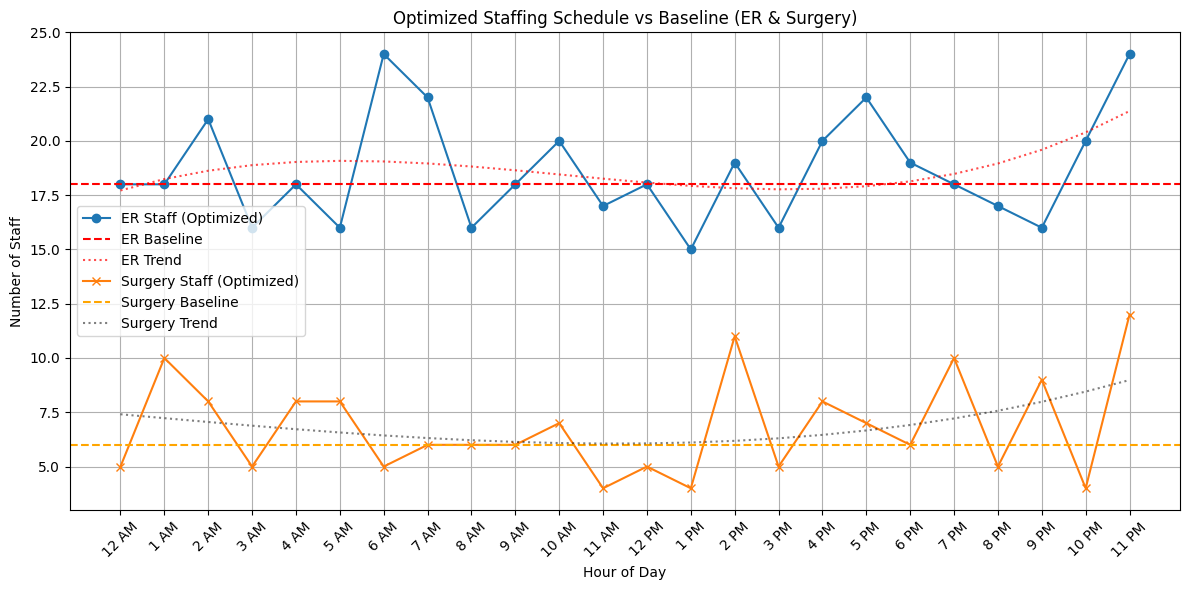

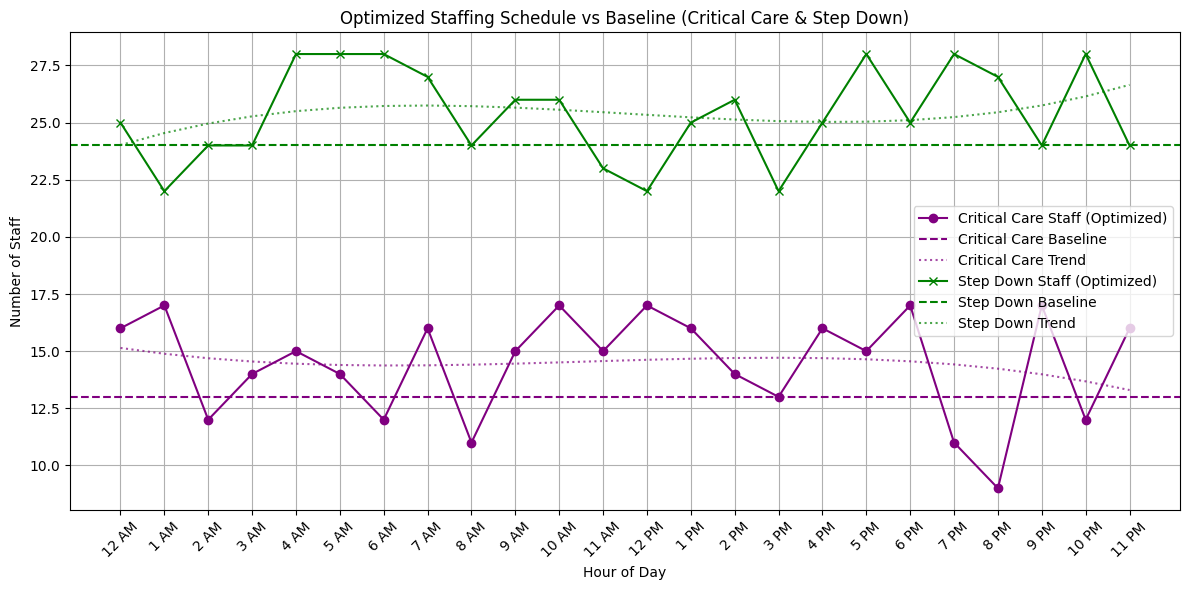

In [5]:
print(f"\nOptimization Complete!")
print(f"Best Minimum Cost Found: ${min_cost:,.2f}")
print(f"Baseline Cost: ${baseline_cost:,.2f}")
print(f"Savings: ${baseline_cost - min_cost:,.2f}")

# Visualize the Best Schedule
import matplotlib.pyplot as plt
import numpy as np

hours = list(range(24))
er_staff = [best_schedule[h]['ER'] for h in hours]
surgery_staff = [best_schedule[h]['Surgery'] for h in hours]
critical_staff = [best_schedule[h]['CriticalCare'] for h in hours]
stepdown_staff = [best_schedule[h]['StepDown'] for h in hours]

hour_labels = [f"{h%12 or 12} {'AM' if h < 12 else 'PM'}" for h in hours]

# ER and Surgery Graph
plt.figure(figsize=(12, 6))
plt.plot(hours, er_staff, label='ER Staff (Optimized)', marker='o')
if 'INITIAL_STAFF' in globals():
    plt.axhline(y=INITIAL_STAFF['ER'], color='r', linestyle='--', label='ER Baseline')

# Trend line for ER
z_er = np.polyfit(hours, er_staff, 3)
p_er = np.poly1d(z_er)
plt.plot(hours, p_er(hours), "r:", alpha=0.7, label='ER Trend')

plt.plot(hours, surgery_staff, label='Surgery Staff (Optimized)', marker='x')
if 'INITIAL_STAFF' in globals():
    plt.axhline(y=INITIAL_STAFF['Surgery'], color='orange', linestyle='--', label='Surgery Baseline')

# Trend line for Surgery
z_surg = np.polyfit(hours, surgery_staff, 3)
p_surg = np.poly1d(z_surg)
plt.plot(hours, p_surg(hours), "k:", alpha=0.5, label='Surgery Trend')

plt.title('Optimized Staffing Schedule vs Baseline (ER & Surgery)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Staff')
plt.xticks(hours, hour_labels, rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Critical Care and Step Down Graph
plt.figure(figsize=(12, 6))
plt.plot(hours, critical_staff, label='Critical Care Staff (Optimized)', marker='o', color='purple')
if 'INITIAL_STAFF' in globals():
    plt.axhline(y=INITIAL_STAFF['CriticalCare'], color='purple', linestyle='--', label='Critical Care Baseline')

# Trend line for Critical Care
z_crit = np.polyfit(hours, critical_staff, 3)
p_crit = np.poly1d(z_crit)
plt.plot(hours, p_crit(hours), color="purple", linestyle=':', alpha=0.7, label='Critical Care Trend')

plt.plot(hours, stepdown_staff, label='Step Down Staff (Optimized)', marker='x', color='green')
if 'INITIAL_STAFF' in globals():
    plt.axhline(y=INITIAL_STAFF['StepDown'], color='green', linestyle='--', label='Step Down Baseline')

# Trend line for Step Down
z_step = np.polyfit(hours, stepdown_staff, 3)
p_step = np.poly1d(z_step)
plt.plot(hours, p_step(hours), color="green", linestyle=':', alpha=0.7, label='Step Down Trend')

plt.title('Optimized Staffing Schedule vs Baseline (Critical Care & Step Down)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Staff')
plt.xticks(hours, hour_labels, rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
# Display Full Best Schedule
print("Best Hourly Staffing Schedule:")
schedule_df = pd.DataFrame.from_dict(best_schedule, orient='index')

total_initial_staff = sum(INITIAL_STAFF.values())
schedule_df['Extra Staff'] = (schedule_df.sum(axis=1) - total_initial_staff).clip(lower=0).astype(int)

def format_hour(h):
    am_pm = "AM" if h < 12 else "PM"
    hour_12 = h if h <= 12 else h - 12
    if hour_12 == 0: hour_12 = 12
    return f"{h} ({hour_12} {am_pm})"

schedule_df.index = [format_hour(h) for h in schedule_df.index]
schedule_df.index.name = 'Hour'
display(schedule_df)

Best Hourly Staffing Schedule:


,ER,Surgery,CriticalCare,StepDown,Extra Staff
Hour,,,,,
0 (12 AM),18,5,16,25,3
1 (1 AM),18,10,17,22,6
2 (2 AM),21,8,12,24,4
3 (3 AM),16,5,14,24,0
4 (4 AM),18,8,15,28,8
5 (5 AM),16,8,14,28,5
6 (6 AM),24,5,12,28,8
7 (7 AM),22,6,16,27,10
8 (8 AM),16,6,11,24,0


---

## 6. Sensitivity Analysis

While the Genetic Algorithm provided an optimal schedule for our baseline arrival rates, real-world hospital environments are highly unpredictable. What happens if there's a sudden surge in patients? Or a surprisingly quiet day?

To test the **robustness** of our optimal schedule, we will perform a Sensitivity Analysis. We will artificially scale the patient arrival rates by various multipliers (from 80% to 120% of normal volume) and observe how our optimized schedule holds up under pressure compared to the baseline schedule.

We'll run 100 simulations for each scenario to get a statistically significant average cost.

In [7]:
import copy
import numpy as np
from simulation.config import ARRIVAL_RATES

def run_sensitivity_analysis(schedule_to_test, multipliers, num_runs=100):
    results = {}
    original_rates = copy.deepcopy(ARRIVAL_RATES)
    
    print(f"Running Sensitivity Analysis across {len(multipliers)} scenarios ({num_runs} runs each)...")
    
    for mult in multipliers:
        # 1. Scale the Arrival Rates
        for hour in original_rates:
            mean, std = original_rates[hour]
            ARRIVAL_RATES[hour] = (mean * mult, std * mult)
            
        # 2. Run Simulations
        scenario_costs = []
        for i in range(num_runs):
            # Disable print statements for speed, if any existed
            sim = HospitalSimulation(duration_hours=24, staffing_schedule=schedule_to_test)
            cost = sim.run()
            scenario_costs.append(cost)
            
        # 3. Record Results
        avg_cost = np.mean(scenario_costs)
        std_cost = np.std(scenario_costs)
        results[mult] = {'avg': avg_cost, 'std': std_cost, 'all_costs': scenario_costs}
        print(f"  Multiplier {mult:.1f}x -> Avg Cost: ${avg_cost:,.2f} (±${std_cost:,.2f})")
        
    # 4. Restore Original Rates
    ARRIVAL_RATES.update(original_rates)
    print("Finished Analysis. restored original config.")
    return results

# Define Scenarios (-20% to +20% volume)
multipliers_to_test = [0.8, 0.9, 1.0, 1.1, 1.2]

# Run for Optimized Schedule
print("--- Testing OPTIMIZED Schedule ---")
opt_results = run_sensitivity_analysis(best_schedule, multipliers_to_test, num_runs=100)

# Run for Baseline Schedule (None means INITIAL_STAFF constantly)
print("\n--- Testing BASELINE Schedule ---")
base_results = run_sensitivity_analysis(None, multipliers_to_test, num_runs=100)


--- Testing OPTIMIZED Schedule ---
Running Sensitivity Analysis across 5 scenarios (100 runs each)...


  Multiplier 0.8x -> Avg Cost: $184,813.63 (±$61,193.96)


  Multiplier 0.9x -> Avg Cost: $201,364.70 (±$55,775.74)


  Multiplier 1.0x -> Avg Cost: $218,244.40 (±$69,532.32)


  Multiplier 1.1x -> Avg Cost: $206,462.85 (±$68,060.16)


  Multiplier 1.2x -> Avg Cost: $226,616.88 (±$62,188.51)
Finished Analysis. restored original config.

--- Testing BASELINE Schedule ---
Running Sensitivity Analysis across 5 scenarios (100 runs each)...


  Multiplier 0.8x -> Avg Cost: $235,218.83 (±$70,378.88)


  Multiplier 0.9x -> Avg Cost: $237,619.77 (±$70,241.22)


  Multiplier 1.0x -> Avg Cost: $247,287.86 (±$71,787.73)


  Multiplier 1.1x -> Avg Cost: $265,347.95 (±$86,803.27)


  Multiplier 1.2x -> Avg Cost: $280,652.93 (±$87,711.91)
Finished Analysis. restored original config.


### Visualizing Robustness

Let's visualize how the costs scale as patient volume increases. A good schedule should not only be cheaper at 1.0x volume but should scale more gracefully when volume spikes.

<>:19: SyntaxWarning: invalid escape sequence '\$'
<>:19: SyntaxWarning: invalid escape sequence '\$'
/var/folders/vb/xwbqv9pd6wjb16g61t0mf7bm0000gn/T/ipykernel_63255/776639875.py:19: SyntaxWarning: invalid escape sequence '\$'
  plt.ylabel('Average Total Daily Cost (\$)', fontsize=12)
/var/folders/vb/xwbqv9pd6wjb16g61t0mf7bm0000gn/T/ipykernel_63255/776639875.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['${:,.0f}'.format(x) for x in current_values])


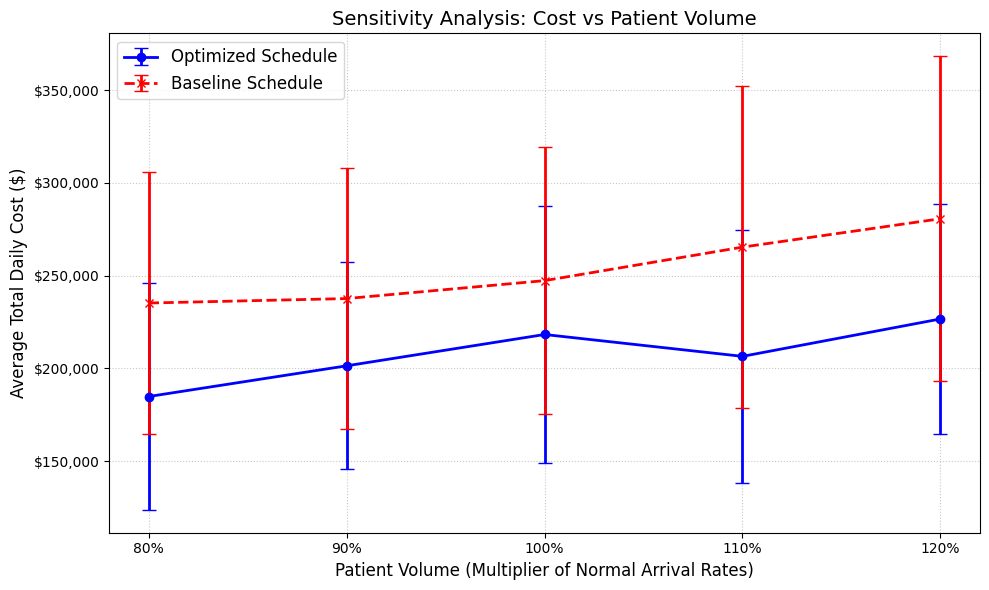

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Extract data
x_vals = [f"{m*100:.0f}%" for m in multipliers_to_test]
opt_avgs = [opt_results[m]['avg'] for m in multipliers_to_test]
opt_errs = [opt_results[m]['std'] for m in multipliers_to_test]

base_avgs = [base_results[m]['avg'] for m in multipliers_to_test]
base_errs = [base_results[m]['std'] for m in multipliers_to_test]

# Plot lines with error bands
plt.errorbar(x_vals, opt_avgs, yerr=opt_errs, label='Optimized Schedule', marker='o', capsize=5,  linestyle='-', linewidth=2, color='blue')
plt.errorbar(x_vals, base_avgs, yerr=base_errs, label='Baseline Schedule', marker='x', capsize=5, linestyle='--', linewidth=2, color='red')

plt.title('Sensitivity Analysis: Cost vs Patient Volume', fontsize=14)
plt.xlabel('Patient Volume (Multiplier of Normal Arrival Rates)', fontsize=12)
plt.ylabel('Average Total Daily Cost (\$)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12)

# Format Y-axis with commas
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,.0f}'.format(x) for x in current_values])

plt.tight_layout()
plt.show()


### Conclusion

The sensitivity analysis demonstrates the true value of the optimized schedule. Not only does it provide significant cost savings during normal operations (100% volume), but it acts as a buffer against unexpected surges in patient arrivals. 

As volume increases to 110% or 120%, the cost of the baseline schedule typically skyrockets due to massive waiting times and ambulance diversions. The optimized schedule, having distributed staff more intelligently across peak hours, handles the extra load much more gracefully.